Irena Vent

## Natural Language Processing
## 1. Análisis exploratorio de los datos

*   **data**: Amazon Reviews
*   **dataset**: Musical Instruments
*   **obetivo**: obtener un modelo de clasificación binaria que clasifique si una reseña es positiva o negativa

## Preparación del entorno

In [5]:
! wget https://transfer.sh/JGREuX/requirements.txt

--2022-06-18 12:41:37--  https://transfer.sh/JGREuX/requirements.txt
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236 [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]     236  --.-KB/s    in 0s      

2022-06-18 12:41:38 (71.9 MB/s) - ‘requirements.txt.1’ saved [236/236]



In [6]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# se utiliza para ver las variables más importante chi2
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

## Carga de datos

In [23]:
#! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz

In [10]:
#import gzip
#f=gzip.open("./reviews_Musical_Instruments_5.json.gz",'rb')
#file_content=f.read()
#print(file_content)

In [57]:
# drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# cargamos Corpus desde drive
data = pd.read_json('/content/drive/MyDrive/reviews_Musical_Instruments_5.json', lines = True)

# mostramos data
print('Tamaño data -->', data.shape)
pd.set_option('display.max_columns', None)
data.head(5)

Tamaño data --> (10261, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Eliminamos columnas no relevantes 

In [59]:
# comprobamos datos
data.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Nos quedamos con las columnas:


*   reviewText
*   overall



In [60]:
# eliminamos las columnas 
data = data.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis = 1)
print('Tamaño del dataset tras elminar columnas -->', data.shape)

Tamaño del dataset tras elminar columnas --> (10261, 2)


## Distribución de de reviews según número de estrellas

In [61]:
set(data['overall'])

{1, 2, 3, 4, 5}

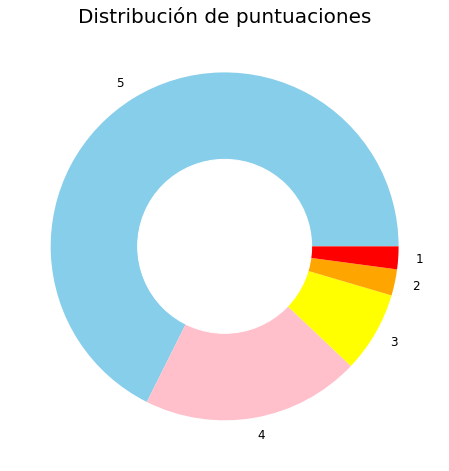

In [78]:
# preparamos los datos
score = data['overall'].value_counts()
numbers = score.index
quantity = score.values

# visualizamos las distribuciones
custom_colors = ['skyblue', 'pink', 'yellow', 'orange', 'red']
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title('Distribución de puntuaciones', fontsize=20)
plt.show()

## Convertimos variable objetivo (reviews) en variable bianria

In [79]:
# nota de conversión:
# overall < 3 == negativa = 0
# overall > 3 == positiva = 1

# conversión
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 0
    else:
        return 1

data['sentiment_label'] = data.apply(lambda row: label_sentiment(row), axis=1)

In [80]:
data.head(5)

,reviewText,overall,sentiment_label
0,"Not much to write about here, but it does exac...",5,1
1,The product does exactly as it should and is q...,5,1
2,The primary job of this device is to block the...,5,1
3,Nice windscreen protects my MXL mic and preven...,5,1
4,This pop filter is great. It looks and perform...,5,1


## Distribución del dataset según tipo de reseña